In [2]:
import os
import sys
from collections import defaultdict
from functools import reduce, partial
from typing import List, Set, Tuple, Union

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from Bio.Data import CodonTable
from Bio.Data.CodonTable import NCBICodonTableDNA
from Bio import SeqIO

from mutspec.utils import read_genbank_ref, calculate_mutspec, CodonAnnotation

### Observed mutations

In [3]:
##### read observed and merge it with annotation in order to annotate
path_to_obs = "../data/external/CancerDataFromCampbell/mtDNA_snv_Oct2016.txt"
_cols = "position,ref,var,tissue,Annot,Unnamed: 34,Unnamed: 35,is_nonsense".split(",")
ObsAll = pd.read_csv(path_to_obs, sep="\t", usecols=_cols)
ObsAll.head()

,tissue,position,ref,var,Annot,Unnamed: 34,Unnamed: 35,is_nonsense
0,BLCA,2680,T,C,"ncUTR,MT-RNR2,MT-RNR2,exon1,,,1;",CCAGTGAAAT,GACCTGCCCG,0
1,BLCA,6011,T,C,"synSNP,MT-CO1,MT-CO1,exon1,L36L,5,1;",TAAGCCTCCT,ATTCGAGCCG,0
2,BLCA,7706,G,A,"nsSNP,MT-CO2,MT-CO2,exon1,A41T,0,1;",AGTCCTGTAT,CCCTTTTCCT,0
3,BLCA,9078,T,C,"synSNP,MT-ATP6,MT-ATP6,exon1,I184I,5,1;",TATCAACCAT,AACCTTCCCT,0
4,BLCA,9686,T,C,"synSNP,MT-CO3,MT-CO3,exon1,I160I,5,5;",ACCAAATAAT,CAAGCACTGC,0


In [4]:
ObsAll.is_nonsense.value_counts()

0    7330
1     281
Name: is_nonsense, dtype: int64

### "Expected" mutspec 

### Read reference genbank

In [5]:
path_to_gb = "../data/external/NC_012920.1.gb"
Ref = read_genbank_ref(path_to_gb)
print(Ref.shape)
Ref.to_csv("../data/processed/ref_annot.csv", index=None)
Ref.head(4000)

(16569, 9)


,Pos,Nuc,Context,Strand,Type,GeneName,PosInGene,PosInCodon,Codon
0,1,G,None,-1,D-loop,NaN,-1,-1,NaN
1,2,A,GAT,-1,D-loop,NaN,-1,-1,NaN
2,3,T,ATC,-1,D-loop,NaN,-1,-1,NaN
3,4,C,TCA,-1,D-loop,NaN,-1,-1,NaN
4,5,A,CAC,-1,D-loop,NaN,-1,-1,NaN
...,...,...,...,...,...,...,...,...,...
3995,3996,C,ACA,1,CDS,ND1,690,3,AAC
3996,3997,A,CAT,1,CDS,ND1,691,1,ATT
3997,3998,T,ATT,1,CDS,ND1,692,2,ATT
3998,3999,T,TTA,1,CDS,ND1,693,3,ATT


## Merge only mutations and custom annotation from genbank

In [6]:
ObsAll.head(2)

,tissue,position,ref,var,Annot,Unnamed: 34,Unnamed: 35,is_nonsense
0,BLCA,2680,T,C,"ncUTR,MT-RNR2,MT-RNR2,exon1,,,1;",CCAGTGAAAT,GACCTGCCCG,0
1,BLCA,6011,T,C,"synSNP,MT-CO1,MT-CO1,exon1,L36L,5,1;",TAAGCCTCCT,ATTCGAGCCG,0


In [7]:
Ref.head(2)

,Pos,Nuc,Context,Strand,Type,GeneName,PosInGene,PosInCodon,Codon
0,1,G,None,-1,D-loop,NaN,-1,-1,NaN
1,2,A,GAT,-1,D-loop,NaN,-1,-1,NaN


In [9]:
coda = CodonAnnotation(2)

In [ ]:
coda.get_mut_type

In [23]:
def get_alt(ser: pd.Series):
    if not isinstance(ser["Codon"], str):
        return None
    codon = list(ser["Codon"])
    ref_nuc, alt_nuc = ser["ref"], ser["var"]
    pic = ser["PosInCodon"] - 1
    assert codon[pic] == ref_nuc, "reference nucleotide is not tha same as in codon"
    codon[pic] = alt_nuc
    alt_codon = "".join(codon)
    return alt_codon
    
ObsAllAnn = pd.merge(
    ObsAll[["tissue", "position", "ref", "var", "Annot", "is_nonsense"]], 
    Ref, left_on=["position", "ref"], right_on=["Pos", "Nuc"],
)
ObsAllAnn["AltCodon"] = ObsAllAnn.apply(get_alt, axis=1)
ObsAllAnn["Label"] = ObsAllAnn.apply(
    lambda s: 0 if s.PosInCodon <= 0 else coda.get_mut_type(
        s.Codon, s.AltCodon, s.PosInCodon - 1)[0], axis=1)

ObsAllAnn.head()

,tissue,position,ref,var,Annot,is_nonsense,Pos,Nuc,Context,Strand,Type,GeneName,PosInGene,PosInCodon,Codon,AltCodon,Label
0,BLCA,2680,T,C,"ncUTR,MT-RNR2,MT-RNR2,exon1,,,1;",0,2680,T,TTG,1,rRNA,RNR2,-1,-1,NaN,None,0
1,PAEN,2680,T,C,"ncUTR,MT-RNR2,MT-RNR2,exon1,,,1;",0,2680,T,TTG,1,rRNA,RNR2,-1,-1,NaN,None,0
2,BLCA,6011,T,C,"synSNP,MT-CO1,MT-CO1,exon1,L36L,5,1;",0,6011,T,TTA,1,CDS,COX1,108,3,CTT,CTC,2
3,BLCA,7706,G,A,"nsSNP,MT-CO2,MT-CO2,exon1,A41T,0,1;",0,7706,G,TGC,1,CDS,COX2,121,1,GCC,ACC,0
4,LIRI,7706,G,A,"nsSNP,MT-CO2,MT-CO2,exon1,A41T,0,1;",0,7706,G,TGC,1,CDS,COX2,121,1,GCC,ACC,0


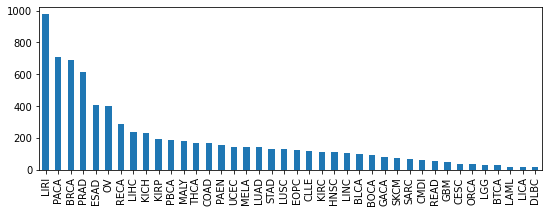

In [24]:
plt.figure(figsize=(9, 3))
ObsAllAnn.tissue.value_counts().plot.bar();

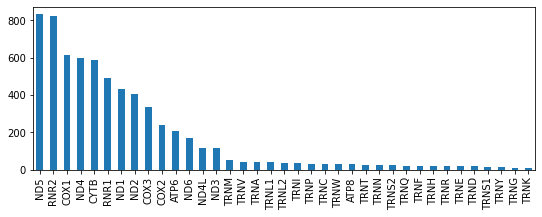

In [25]:
plt.figure(figsize=(9, 3))
ObsAllAnn.GeneName.value_counts().plot.bar();

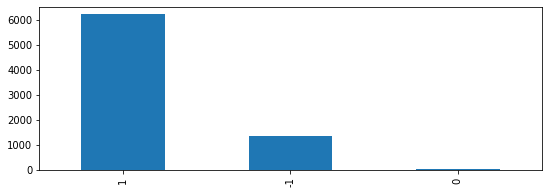

In [38]:
plt.figure(figsize=(9, 3))
ObsAllAnn.Strand.value_counts().plot.bar();

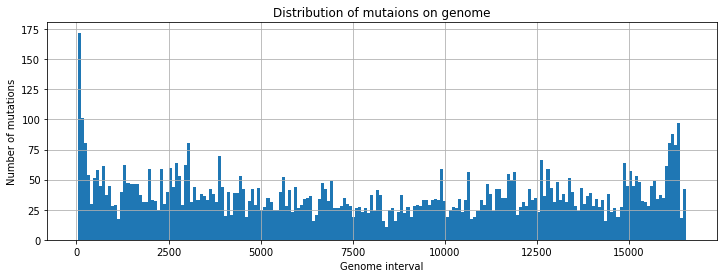

In [37]:
plt.figure(figsize=(12, 4))
plt.title("Distribution of mutaions on genome")
plt.xlabel("Genome interval")
plt.ylabel("Number of mutations")
ObsAllAnn.Pos.hist(bins=200);

In [26]:
ObsAllAnn["Mut"] = ObsAllAnn.Context.str.get(0) + "[" + ObsAllAnn["ref"] + ">" + ObsAllAnn["var"] + "]" + ObsAllAnn.Context.str.get(-1)

In [28]:
Mut = ObsAllAnn[["Pos", "Mut", "Strand", "GeneName", "tissue", "Label"]]
Mut.head()

,Pos,Mut,Strand,GeneName,tissue,Label
0,2680,T[T>C]G,1,RNR2,BLCA,0
1,2680,T[T>C]G,1,RNR2,PAEN,0
2,6011,T[T>C]A,1,COX1,BLCA,2
3,7706,T[G>A]C,1,COX2,BLCA,0
4,7706,T[G>A]C,1,COX2,LIRI,0


Что сделать?
+ импортировать(!!!), установив свой пакет мутспек в био-енв, класс для парсинга кодонов
+ залить туда функцию парсинга генбанка
+ заменить глупые is_syn & is_ff на стандартный лейбл, там лежит функция ~ get_mut_type
- получить частоты тринуклеотидов и нуклеотидов простым подсчетом из Ref таблицы
- воспользоваться уже написанной функцией подсчета мутспека. Ее нужно подправить - добавить вариант когда нужно считать дискретные состояния, а не вероятности, еще один аргумент

In [ ]:
from Bio import codonalign

In [ ]:
codonalign.CodonAlignment.